In [2]:
# 📌 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from google.colab import files

# 📌 2. Load dataset
uploaded = files.upload()
df = pd.read_csv("wfp_food_prices_database.csv", low_memory=False)

# 📌 3. Initial cleanup
df = df.drop_duplicates()
df = df.dropna(subset=['mp_price'])

# 📌 4. Outlier removal on target (mp_price)
Q1 = df['mp_price'].quantile(0.25)
Q3 = df['mp_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.0 * IQR
upper_bound = Q3 + 1.0 * IQR
df = df[(df['mp_price'] >= lower_bound) & (df['mp_price'] <= upper_bound)]

# 📌 5. Cyclical encoding for month
df['mp_month'] = df['mp_month'].astype(int)
df['mp_month_sin'] = np.sin(2 * np.pi * (df['mp_month'] - 1) / 12)
df['mp_month_cos'] = np.cos(2 * np.pi * (df['mp_month'] - 1) / 12)

# 📌 6. Region mean price feature
df["adm1_mean_price"] = df.groupby("adm1_id")["mp_price"].transform("mean")

# 📌 7. Define ID-based features and target
features = [
    'cm_id', 'adm0_id', 'adm1_id', 'cur_id', 'pt_id', 'um_id',
    'mp_month_sin', 'mp_month_cos', 'mp_year', 'adm1_mean_price'
]
target = 'mp_price'

# 📌 8. Drop rows with missing in final feature set
df = df.dropna(subset=features + [target])

# 📌 9. Prepare X and y
X = df[features].copy()
y = df[target]

# 📌 10. Train-test split (on full dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 11. Train model using best setup (D)
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)
model.fit(X_train, y_train)

# 📌 12. Evaluate model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n🏁 FINAL EVALUATION — ID-Based Model (100% dataset, Setup D):")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")


Saving wfp_food_prices_database.csv to wfp_food_prices_database.csv


<ipython-input-2-8b1cce05b878>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mp_month'] = df['mp_month'].astype(int)



🏁 FINAL EVALUATION — ID-Based Model (100% dataset, Setup D):
MAE:  57.76
RMSE: 108.05
R²:   0.899


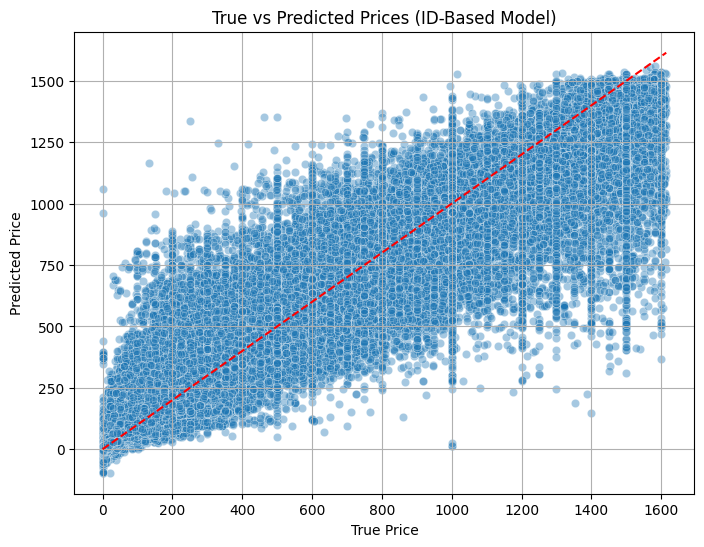

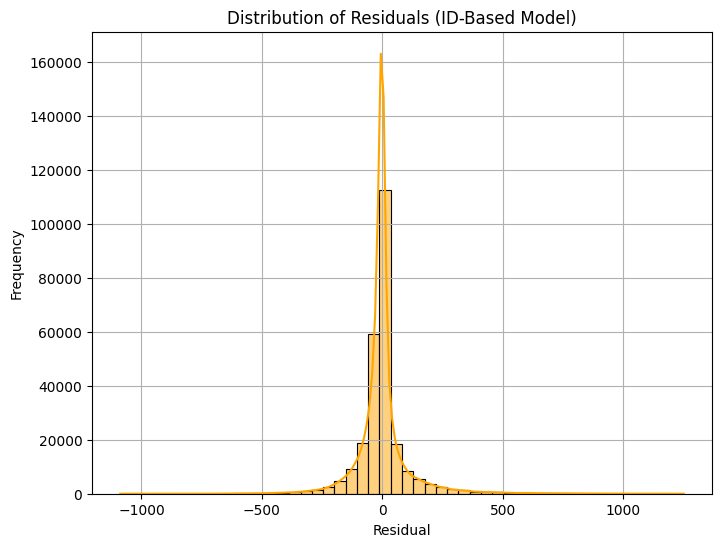

<ipython-input-3-95d8be3344ff>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


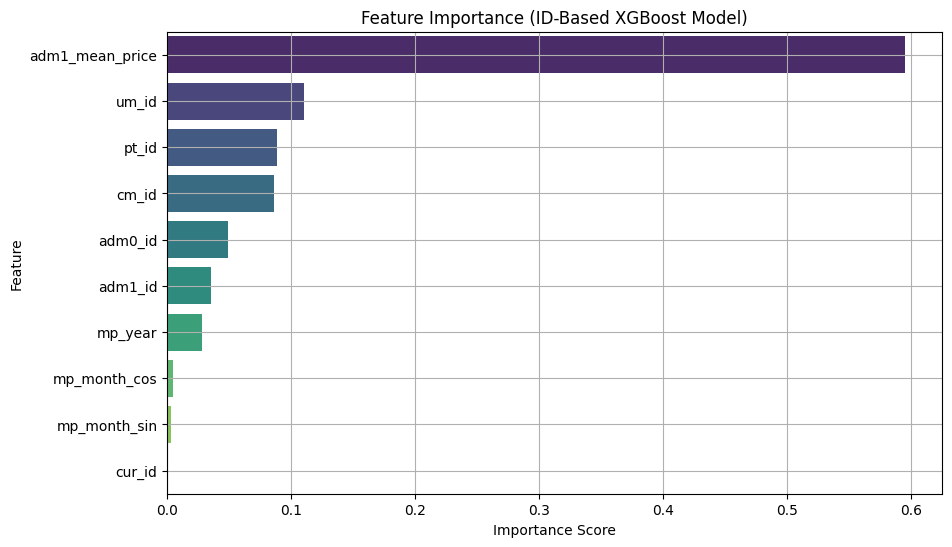

In [3]:
# 📊 Visualization for Name-Based XGBoost Model (Full Dataset)

import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Scatter Plot: True vs Predicted Prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y = x line
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Prices (ID-Based Model)")
plt.grid(True)
plt.show()

# 2️⃣ Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50, color='orange')
plt.title("Distribution of Residuals (ID-Based Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3️⃣ Feature Importance Plot
importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance (ID-Based XGBoost Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


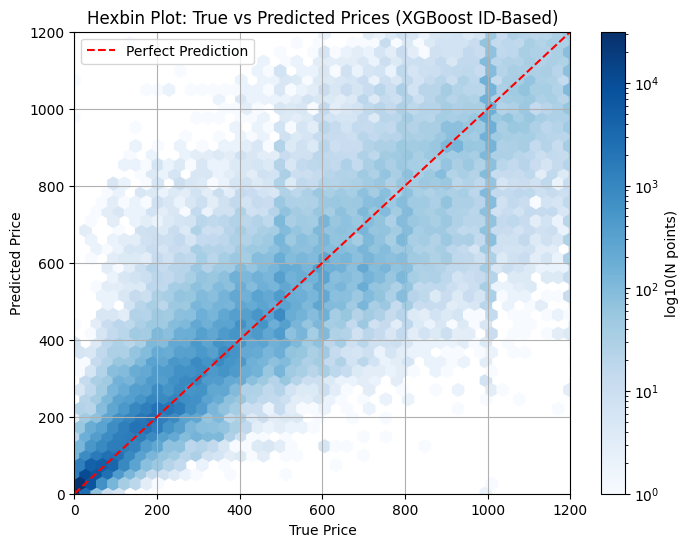

In [4]:

plt.figure(figsize=(8, 6))
plt.hexbin(y_test, y_pred, gridsize=60, cmap="Blues", bins='log')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Hexbin Plot: True vs Predicted Prices (XGBoost ID-Based)")
plt.colorbar(label="log10(N points)")
plt.grid(True)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.legend()
plt.show()


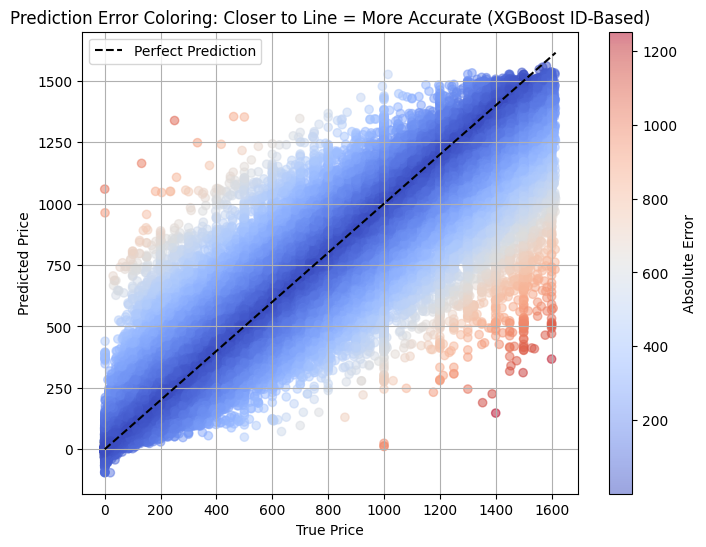

In [5]:
import numpy as np
import matplotlib.pyplot as plt

errors = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Prediction Error Coloring: Closer to Line = More Accurate (XGBoost ID-Based)")
plt.colorbar(sc, label="Absolute Error")
plt.grid(True)
plt.legend()
plt.show()
